In [1]:
import json
from transformers import pipeline
from ragas.metrics import RougeScore, BleuScore, ExactMatch, StringPresence
from ragas.metrics._string import NonLLMStringSimilarity
from ragas.evaluation import EvaluationDataset, evaluate
from ragas.dataset_schema import SingleTurnSample
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def mdeberta_v3_base_squad2(rag_model_name):

    # Modeli yükleme
    qa_model = pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

    # JSON dosyasını yükleme
    input_path = f"./RAG Model Çıktıları/{rag_model_name}_updated_answers.json"
    with open(input_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    # Tahminleri ve sonuçları toplama
    results = []
    for item in data["results"]:
        # Context'i birleştirme
        context = item["model_answer"]
        question = item["question"]
        real_answer = item["real_answer"]

        # Modelden cevap tahmini
        try:
            model_output = qa_model({
                'question': question,
                'context': context
            })
            model_answer = model_output['answer']
        except Exception as e:
            model_answer = f"Model tahmin edemedi: {e}"

        # Sonuçları kaydetme
        results.append({
            "context": context,
            "question": question,
            "real_answer": real_answer,
            "model_answer": model_answer
        })

    # Sonuçları updated_answers dosyasına yazma
    output_path = f"./RAG Modelleri & mdeberta-v3-base-squad2/{rag_model_name}_updated_answers.json"
    with open(output_path, "w", encoding="utf-8") as outfile:
        json.dump({"results": results}, outfile, ensure_ascii=False, indent=4)

    print(f"Cevaplar '{output_path}' dosyasına yazıldı.")

In [3]:
def ragas_metric_calculation(model_name):

    # OpenAI API anahtarını ayarlama
    os.environ["OPENAI_API_KEY"] = "" #Kendi API key'iniz ile doldurun.

    # JSON dosyasını yükleme
    with open(f"./RAG Modelleri & mdeberta-v3-base-squad2/{model_name}_updated_answers.json", "r", encoding="utf-8") as f:
        data = json.load(f)

    # Veri örneklerini JSON'dan SingleTurnSample formatına dönüştürme
    samples = [
        SingleTurnSample(
            user_input=item["question"],
            retrieved_contexts=[" ".join(item["context"])],  # Context listesi birleştirilir
            response=item["model_answer"],
            reference=item["real_answer"]
        )
        for item in data["results"]
    ]

    # Değerlendirme veri setini oluşturma
    dataset = EvaluationDataset(samples=samples)

    # Değerlendirmeyi gerçekleştirme
    results = evaluate(dataset, metrics=[RougeScore(), BleuScore(), ExactMatch(), StringPresence(),NonLLMStringSimilarity()])

    # Sonuçları analiz etme
    df = results.to_pandas()
    display(df.head())  # İlk birkaç sonucu ekrana yazdırma

    # Sonuçları bir CSV dosyasına kaydetme (isteğe bağlı)
    output_path = f"./RAG Modelleri & mdeberta-v3-base-squad2/{model_name}_ragas_evaluation_results.csv"
    df.to_csv(output_path, index=False)
    print(f"Sonuçlar '{output_path}' dosyasına kaydedildi.")

In [4]:
scores = {
    "model": [],
    "bleu": [],
    "rouge": [],
    "exact_match": [],
    "string_present": [],
    "string_similarity": []
    }

def average_ragas_scores(model_name):
    # CSV dosyasını okuma
    file_path = f"./RAG Modelleri & mdeberta-v3-base-squad2/{model_name}_ragas_evaluation_results.csv"  # Dosya adınızı buraya yazın
    df = pd.read_csv(file_path)

    # Ortalama BLEU ve ROUGE skorlarını hesaplama
    average_bleu = df["bleu_score"].mean()
    average_rouge = df["rouge_score"].mean()
    average_exact_match = df["exact_match"].mean()
    average_string_present = df["string_present"].mean()
    average_non_llm_string_similarity = df["non_llm_string_similarity"].mean()

    scores["model"].append(model_name)
    scores["bleu"].append(average_bleu)
    scores["rouge"].append(average_rouge)
    scores["exact_match"].append(average_exact_match)
    scores["string_present"].append(average_string_present)
    scores["string_similarity"].append(average_non_llm_string_similarity)

    # Sonuçları yazdırma
    print(f"Ortalama BLEU Skoru: {average_bleu:.3f}")
    print(f"Ortalama ROUGE Skoru: {average_rouge:.3f}")
    print(f"Ortalama Exact Match Skoru: {average_exact_match:.3f}")
    print(f"Ortalama String Present Skoru: {average_string_present:.3f}")
    print(f"Ortalama String Similarity Skoru: {average_non_llm_string_similarity:.3f}")

In [5]:
rag_models = [
    "jinaaijina-colbert-v2",
    "ytu-ce-cosmosturkish-colbert",
    "andreascharicolbert-xm-lt-cafr"
]

for rag_model in rag_models:
    mdeberta_v3_base_squad2(rag_model)
    print(f"\n\n{rag_model} modeline ait RAGAS ölçüm sonuçları aşağıdaki gibidir.")
    ragas_metric_calculation(rag_model)
    print(f"\n\n{rag_model} modeline ait ortalama RAGAS ölçüm sonuçları aşağıdaki gibidir.")
    average_ragas_scores(rag_model)

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

d:\Python\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anday\.cache\huggingface\hub\models--timpal0l--mdeberta-v3-base-squad2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0
d:\Python\lib\site-packages\transformers\pipelines\question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Cevaplar './RAG Modelleri & mdeberta-v3-base-squad2/jinaaijina-colbert-v2_updated_answers.json' dosyasına yazıldı.


jinaaijina-colbert-v2 modeline ait RAGAS ölçüm sonuçları aşağıdaki gibidir.


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

,user_input,retrieved_contexts,response,reference,rouge_score,bleu_score,exact_match,string_present,non_llm_string_similarity
0,Fenerbahçe'nin transferden en çok gelir elde e...,[2 0 2 3 / 2 0 2 4 s e z o n u n d a f e n...,2023/2024,2023/2024,1.0,0.0,1.0,1.0,1.000000
1,Fenerbahçe'nin transferden en az gelir elde et...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022,2021/2022,1.0,0.0,1.0,1.0,1.000000
2,Türkiye'nin turizm gelirlerinin en yüksek oldu...,[2 0 2 2 y ı l ı n d a t u r i z m g e l...,2022,2022,1.0,0.0,1.0,1.0,1.000000
3,Türkiye'nin turizm gelirlerinin en düşük olduğ...,[t ü r k i y e ' d e t u r i z m g e l i r...,2020,2020,1.0,0.0,0.0,1.0,0.800000
4,2005/2006 sezonunda 25 golden daha fazla gol a...,[a l e x d e s o u z a 2 0 0 5 / 2 0 0 6...,alex de souza,Alex de Souza,1.0,0.0,0.0,0.0,0.846154


Sonuçlar './RAG Modelleri & mdeberta-v3-base-squad2/jinaaijina-colbert-v2_ragas_evaluation_results.csv' dosyasına kaydedildi.


jinaaijina-colbert-v2 modeline ait ortalama RAGAS ölçüm sonuçları aşağıdaki gibidir.
Ortalama BLEU Skoru: 0.012
Ortalama ROUGE Skoru: 0.531
Ortalama Exact Match Skoru: 0.080
Ortalama String Present Skoru: 0.360
Ortalama String Similarity Skoru: 0.545


Device set to use cuda:0
d:\Python\lib\site-packages\transformers\pipelines\question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


Cevaplar './RAG Modelleri & mdeberta-v3-base-squad2/ytu-ce-cosmosturkish-colbert_updated_answers.json' dosyasına yazıldı.


ytu-ce-cosmosturkish-colbert modeline ait RAGAS ölçüm sonuçları aşağıdaki gibidir.


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

,user_input,retrieved_contexts,response,reference,rouge_score,bleu_score,exact_match,string_present,non_llm_string_similarity
0,Fenerbahçe'nin transferden en çok gelir elde e...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022,2023/2024,0.0,0.0,0.0,0.0,0.777778
1,Fenerbahçe'nin transferden en az gelir elde et...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022,2021/2022,1.0,0.0,1.0,1.0,1.000000
2,Türkiye'nin turizm gelirlerinin en yüksek oldu...,[2 0 2 2 y ı l ı n d a t u r i z m g e l...,2022,2022,1.0,0.0,1.0,1.0,1.000000
3,Türkiye'nin turizm gelirlerinin en düşük olduğ...,[t ü r k i y e ' d e t u r i z m g e l i r...,2020,2020,1.0,0.0,0.0,1.0,0.800000
4,2005/2006 sezonunda 25 golden daha fazla gol a...,[a l e x d e s o u z a 2 0 0 5 / 2 0 0 6...,alex de souza,Alex de Souza,1.0,0.0,0.0,0.0,0.846154


Sonuçlar './RAG Modelleri & mdeberta-v3-base-squad2/ytu-ce-cosmosturkish-colbert_ragas_evaluation_results.csv' dosyasına kaydedildi.


ytu-ce-cosmosturkish-colbert modeline ait ortalama RAGAS ölçüm sonuçları aşağıdaki gibidir.
Ortalama BLEU Skoru: 0.012
Ortalama ROUGE Skoru: 0.438
Ortalama Exact Match Skoru: 0.080
Ortalama String Present Skoru: 0.320
Ortalama String Similarity Skoru: 0.486


Device set to use cuda:0
d:\Python\lib\site-packages\transformers\pipelines\question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


Cevaplar './RAG Modelleri & mdeberta-v3-base-squad2/andreascharicolbert-xm-lt-cafr_updated_answers.json' dosyasına yazıldı.


andreascharicolbert-xm-lt-cafr modeline ait RAGAS ölçüm sonuçları aşağıdaki gibidir.


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

,user_input,retrieved_contexts,response,reference,rouge_score,bleu_score,exact_match,string_present,non_llm_string_similarity
0,Fenerbahçe'nin transferden en çok gelir elde e...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022,2023/2024,0.0,0.0,0.0,0.0,0.777778
1,Fenerbahçe'nin transferden en az gelir elde et...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022,2021/2022,1.0,0.0,1.0,1.0,1.000000
2,Türkiye'nin turizm gelirlerinin en yüksek oldu...,[2 0 2 2 y ı l ı n d a t u r i z m g e l...,2022,2022,1.0,0.0,1.0,1.0,1.000000
3,Türkiye'nin turizm gelirlerinin en düşük olduğ...,[t ü r k i y e ' d e t u r i z m g e l i r...,2020,2020,1.0,0.0,0.0,1.0,0.800000
4,2005/2006 sezonunda 25 golden daha fazla gol a...,[n i c o l a s a n e l k a 2 0 0 5 / 2 0 0...,nicolas anelka,Alex de Souza,0.0,0.0,0.0,0.0,0.142857


Sonuçlar './RAG Modelleri & mdeberta-v3-base-squad2/andreascharicolbert-xm-lt-cafr_ragas_evaluation_results.csv' dosyasına kaydedildi.


andreascharicolbert-xm-lt-cafr modeline ait ortalama RAGAS ölçüm sonuçları aşağıdaki gibidir.
Ortalama BLEU Skoru: 0.012
Ortalama ROUGE Skoru: 0.471
Ortalama Exact Match Skoru: 0.040
Ortalama String Present Skoru: 0.280
Ortalama String Similarity Skoru: 0.493


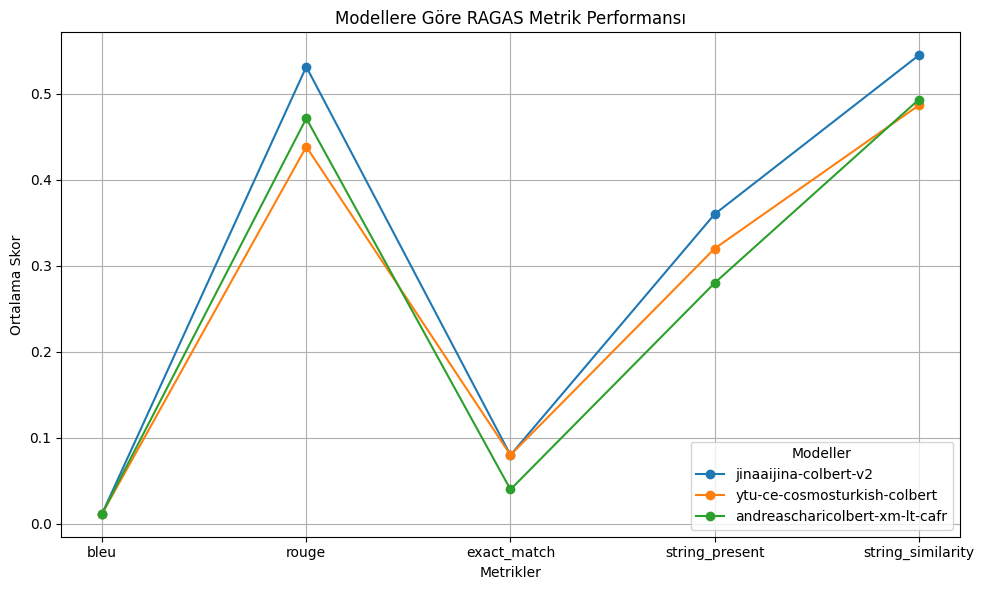

In [6]:
def plot_metrics_by_model(scores):
    metrics = ["bleu", "rouge", "exact_match", "string_present", "string_similarity"]
    metric_labels = {
        "bleu": "BLEU",
        "rouge": "ROUGE",
        "exact_match": "Exact Match",
        "string_present": "String Present",
        "string_similarity": "String Similarity"
    }

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, model in enumerate(scores["model"]):
        ax.plot(
            metrics, 
            [scores[metric][i] for metric in metrics], 
            marker="o", 
            label=model
        )
    
    ax.set_xlabel("Metrikler")
    ax.set_ylabel("Ortalama Skor")
    ax.set_title("Modellere Göre RAGAS Metrik Performansı")
    ax.legend(title="Modeller")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Çizgi grafiği: Metrikler X ekseninde, modeller çizgilerde
plot_metrics_by_model(scores)

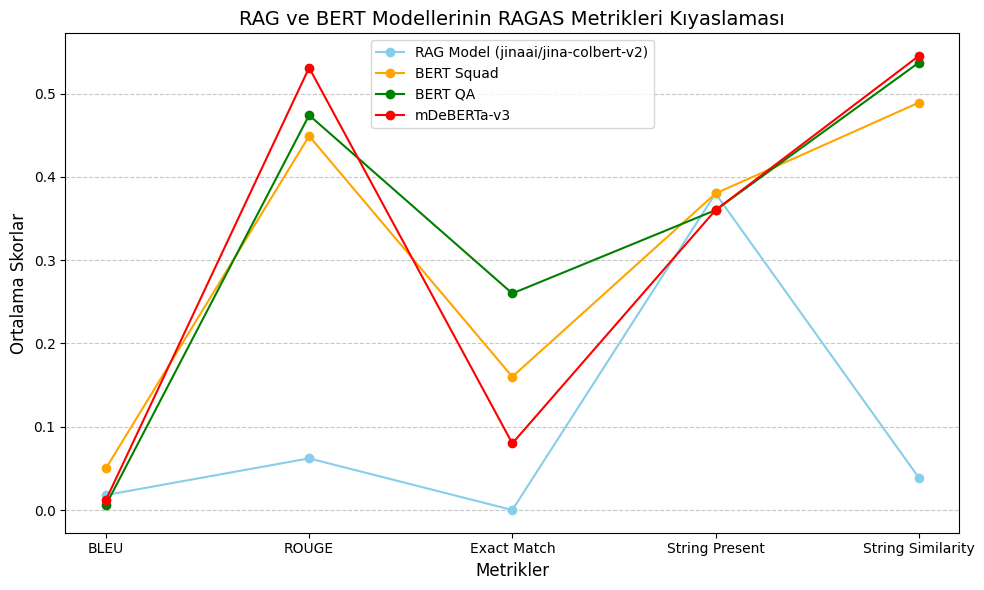

In [9]:
import matplotlib.pyplot as plt

# Veriler
metrics = ["BLEU", "ROUGE", "Exact Match", "String Present", "String Similarity"]
rag_model_scores = [0.018, 0.062, 0.000, 0.380, 0.039]
bert_squad_scores = [0.050, 0.449, 0.160, 0.380, 0.489]
bert_qa_scores = [0.006, 0.474, 0.260, 0.360, 0.537]
mdeberta_scores = [0.012, 0.531, 0.080, 0.360, 0.545]

# Grafiği oluşturma
plt.figure(figsize=(10, 6))

# Çizgiler
plt.plot(metrics, rag_model_scores, marker='o', label='RAG Model (jinaai/jina-colbert-v2)', color='skyblue')
plt.plot(metrics, bert_squad_scores, marker='o', label='BERT Squad', color='orange')
plt.plot(metrics, bert_qa_scores, marker='o', label='BERT QA', color='green')
plt.plot(metrics, mdeberta_scores, marker='o', label='mDeBERTa-v3', color='red')

# Etiketler ve başlık
plt.title('RAG ve BERT Modellerinin RAGAS Metrikleri Kıyaslaması', fontsize=14)
plt.xlabel('Metrikler', fontsize=12)
plt.ylabel('Ortalama Skorlar', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Gösterim
plt.show()
